In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

n_epochs = 2000
n_epochs_latent=20000
batch_size = 10
LR = 2e-5
Lv1_latent_dim = 16
max_loss = 3e-4

alpha = 100

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

"""
data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]
"""
"""
del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

"""
del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]
del(data)



# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [11]:
# validate
data.shape

(1, 14300, 8000)

## FOM data type : FOM_data = np.array[param, time, node, var]

In [12]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

In [13]:
x_axis = np.linspace(0,num_node,num_node)

In [14]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

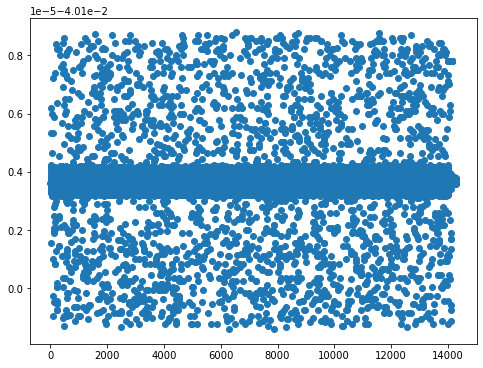

In [15]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [16]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0400963761125
-0.0489409761125
-0.0413117761125
-0.040096287525


In [17]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [18]:
print(maximum)
print(minimum)
print(mean)
print(AT)

0.14354273825
-0.13646576825
-1.5900257024002243e-20
0.2800085065


In [19]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [20]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.5126370625100992
-0.48736293748990095


In [21]:
FOM_data.shape

(10, 800, 14300, 1)

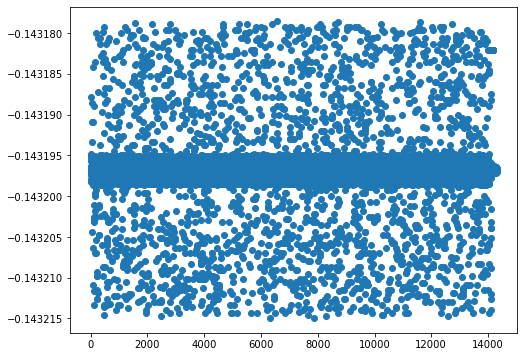

In [22]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [23]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [24]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [25]:
Lv1_input_shape = Lv1_input.shape[1:]

In [26]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


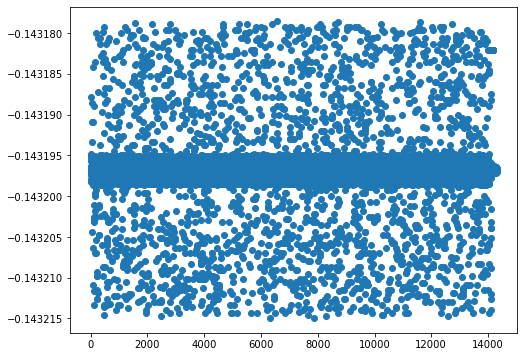

In [27]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Acquire latent vectors

In [28]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

#del Encoder
#del Decoder

epoch = n_epochs
filename1='test_constrained/encoder_%d.h5' % (epoch)
filename2='test_constrained/decoder_%d.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14300, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 14300, 8)     48          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14300, 8)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14300, 8)     0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [29]:
n_epochs_latent

20000

In [30]:
latent_vector_save=np.zeros([num_param, num_time, Lv1_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #print(eps.shape)
    #print(tf.math.sqrt(var).shape)
    #print(mu.shape)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    mu, var,latent_temp = Encoder(x_train, training=False)
    #print(mu)
    #print(var)
    
    latent_vector = reparam(mu[-1], var[-1])
    ##print(latent_vector)
    latent_vector = np.reshape(latent_vector, [-1, Lv1_latent_dim])
    
    #print(latent_temp)
    #latent_vector = latent_temp
    gen_x, _ = Decoder(latent_vector, training=False)
    #print(latent_vector.shape)
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, num_time, Lv1_latent_dim])

latent_vector = np.zeros([1, Lv1_latent_dim])
loss_save = np.ones([num_param, num_time])*1000
# print(loss_save)

for i in range(n_epochs_latent): 
    for j in range(num_param):
        for k in range(num_time):
            
            x = FOM_data[j, k,:,:]
            x = np.reshape(x,(1,x.shape[0],x.shape[1]))
            #print(latent_vector.shape)
            latent_vector, gen_x = find_latent(x)
            
            loss = tf.math.reduce_mean(tf.math.square(FOM_data[j,k,:,:] - gen_x))
            #print(loss)
            if loss < loss_save[j,k]:
                loss_save[j,k] = loss
                latent_vector_save[j,k] = latent_vector
                #print('1')
                
    del latent_vector
    print('Epoch: {}'.format(i))
    print(np.max(loss_save))
    
    if np.max(loss_save)<max_loss:
        break
        
latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

Epoch: 0
2.0597035884857178
Epoch: 1
1.8693842887878418
Epoch: 2
1.4834202527999878
Epoch: 3
1.0370382070541382
Epoch: 4
0.9775047898292542
Epoch: 5
0.7235512733459473
Epoch: 6
0.6389651298522949
Epoch: 7
0.598273754119873
Epoch: 8
0.598273754119873
Epoch: 9
0.4962314963340759
Epoch: 10
0.417277991771698
Epoch: 11
0.417277991771698
Epoch: 12
0.417277991771698
Epoch: 13
0.3774029612541199
Epoch: 14
0.2580617070198059
Epoch: 15
0.22022570669651031
Epoch: 16
0.22022570669651031
Epoch: 17
0.19938091933727264
Epoch: 18
0.19938091933727264
Epoch: 19
0.19938091933727264
Epoch: 20
0.19938091933727264
Epoch: 21
0.19938091933727264
Epoch: 22
0.10960479825735092
Epoch: 23
0.10960479825735092
Epoch: 24
0.10960479825735092
Epoch: 25
0.10960479825735092
Epoch: 26
0.10960479825735092
Epoch: 27
0.10960479825735092
Epoch: 28
0.10960479825735092
Epoch: 29
0.10960479825735092
Epoch: 30
0.10960479825735092
Epoch: 31
0.10960479825735092
Epoch: 32
0.10960479825735092
Epoch: 33
0.10960479825735092
Epoch: 34


Epoch: 261
0.0017217625863850117
Epoch: 262
0.0017217625863850117
Epoch: 263
0.0017217625863850117
Epoch: 264
0.0017217625863850117
Epoch: 265
0.0017217625863850117
Epoch: 266
0.0017217625863850117
Epoch: 267
0.0017217625863850117
Epoch: 268
0.0017217625863850117
Epoch: 269
0.0017217625863850117
Epoch: 270
0.0017217625863850117
Epoch: 271
0.0017217625863850117
Epoch: 272
0.0017217625863850117
Epoch: 273
0.0017217625863850117
Epoch: 274
0.0017217625863850117
Epoch: 275
0.0017217625863850117
Epoch: 276
0.0017217625863850117
Epoch: 277
0.0017217625863850117
Epoch: 278
0.0017217625863850117
Epoch: 279
0.0017217625863850117
Epoch: 280
0.0017217625863850117
Epoch: 281
0.0017217625863850117
Epoch: 282
0.0017217625863850117
Epoch: 283
0.0017217625863850117
Epoch: 284
0.0017217625863850117
Epoch: 285
0.0017217625863850117
Epoch: 286
0.0017217625863850117
Epoch: 287
0.0017217625863850117
Epoch: 288
0.0017217625863850117
Epoch: 289
0.0017217625863850117
Epoch: 290
0.0017217625863850117
Epoch: 291

Epoch: 511
0.0005000840174034238
Epoch: 512
0.0005000840174034238
Epoch: 513
0.0005000840174034238
Epoch: 514
0.0005000840174034238
Epoch: 515
0.0005000840174034238
Epoch: 516
0.0005000840174034238
Epoch: 517
0.0004114963230676949
Epoch: 518
0.0004114963230676949
Epoch: 519
0.0004114963230676949
Epoch: 520
0.0004114963230676949
Epoch: 521
0.0004114963230676949
Epoch: 522
0.0004114963230676949
Epoch: 523
0.0004114963230676949
Epoch: 524
0.0004114963230676949
Epoch: 525
0.0004114963230676949
Epoch: 526
0.0004114963230676949
Epoch: 527
0.0004114963230676949
Epoch: 528
0.0004114963230676949
Epoch: 529
0.0004114963230676949
Epoch: 530
0.0004114963230676949
Epoch: 531
0.0004114963230676949
Epoch: 532
0.0004114963230676949
Epoch: 533
0.0004114963230676949
Epoch: 534
0.0004114963230676949
Epoch: 535
0.0004114963230676949
Epoch: 536
0.0004114963230676949
Epoch: 537
0.0004114963230676949
Epoch: 538
0.0004114963230676949
Epoch: 539
0.0004114963230676949
Epoch: 540
0.0004114963230676949
Epoch: 541

In [31]:
loss_save

array([[2.03072887e-05, 2.84875350e-05, 3.32799864e-05, ...,
        4.80323479e-06, 1.46652656e-05, 2.64077262e-05],
       [1.52533812e-05, 1.61871103e-05, 5.33975217e-05, ...,
        1.25863426e-05, 2.39285055e-05, 1.15377916e-05],
       [8.16934789e-06, 1.78662940e-05, 6.58264435e-06, ...,
        3.18124294e-05, 1.00824445e-05, 7.00007558e-06],
       ...,
       [1.98819707e-05, 1.22749534e-05, 1.75632540e-05, ...,
        2.60808683e-05, 1.16748079e-05, 8.86579292e-05],
       [2.08617512e-05, 8.13026927e-05, 1.26605628e-05, ...,
        1.42451854e-05, 5.16443579e-05, 1.54652953e-05],
       [1.80868883e-05, 3.01579221e-05, 1.26187979e-05, ...,
        1.00570887e-05, 1.65951733e-05, 8.95714038e-06]])

In [32]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [33]:
for_decoder = np.reshape(latent_vectors, [-1, Lv1_latent_dim])

In [34]:
for_decoder1 = np.zeros([Lv1_latent_dim])
for_decoder1[:] = for_decoder[0,:]
for_decoder2 = np.reshape(for_decoder1, [-1, Lv1_latent_dim])

In [35]:
EX,_ = Decoder(for_decoder2)

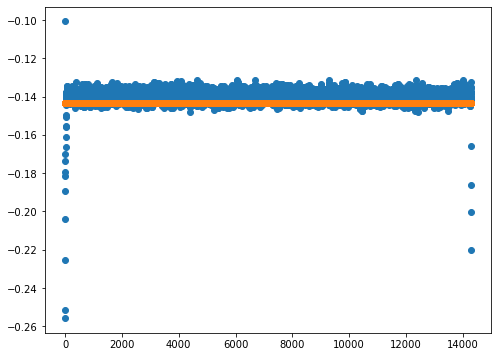

In [36]:
plt.scatter(x_axis, EX[0,:,0])
plt.scatter(x_axis, Lv1_input[0,:,0])

# Output latent vectors to file,

In [37]:
Lv1_latent = latent_vectors

In [38]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [39]:
pause;

NameError: name 'pause' is not defined